In [1]:
# Import libraries and loading packages

import numpy as np # linear algebra
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Models from sklearn library to use in prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Mpdel from sklearn library to split the dataset
from sklearn.model_selection import train_test_split
# Model from sklearn library to gain the validation score using mean absolut error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score

2024-02-14 11:55:45.950432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 11:55:45.950584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 11:55:46.121631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Get the data
First download and import the dataset using pandas:

In [2]:
# importing the data sets
sample_sub = pd.read_csv('/kaggle/input/energy-forecasting-data-challenge-public/sample_submission.csv')
raw_train = pd.read_csv('/kaggle/input/energy-forecasting-data-challenge-public/train.csv')
raw_test = pd.read_csv('/kaggle/input/energy-forecasting-data-challenge-public/test.csv')

In [3]:
# checkin the train dataset
train = raw_train.copy()
test = raw_test.copy()
print(train.tail())
print(test.tail())

                      time    P  Gb(i)  Gd(i)  H_sun   T2m  WS10m   load  \
88707  2020-10-10 22:45:00  0.0    0.0    0.0    0.0  6.49   2.83   99.5   
88708  2020-10-10 23:00:00  0.0    0.0    0.0    0.0  6.39   2.83   96.5   
88709  2020-10-10 23:15:00  0.0    0.0    0.0    0.0  6.34   2.83  100.5   
88710  2020-10-10 23:30:00  0.0    0.0    0.0    0.0  6.30   2.83   97.5   
88711  2020-10-10 23:45:00  0.0    0.0    0.0    0.0  6.26   2.83  102.5   

       residual_load  dataset_id  
88707           99.5          11  
88708           96.5          11  
88709          100.5          11  
88710           97.5          11  
88711          102.5          11  
                     time  Gb(i)  Gd(i)  H_sun   T2m  WS10m  dataset_id
7387  2020-10-17 22:45:00    0.0    0.0    0.0  4.25   1.38          11
7388  2020-10-17 23:00:00    0.0    0.0    0.0  4.16   1.38          11
7389  2020-10-17 23:15:00    0.0    0.0    0.0  4.06   1.40          11
7390  2020-10-17 23:30:00    0.0    0.0    0.

### Prepare data set
in this step I will add separate year month and day columns from the date-time column.

In [4]:
train['Year'] = pd.DatetimeIndex(train['time']).year  
train['Month'] = pd.DatetimeIndex(train['time']).month
train['Day'] = pd.DatetimeIndex(train['time']).day
train['Day_of_week'] = pd.DatetimeIndex(train['time']).weekday
train

,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id,Year,Month,Day,Day_of_week
0,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,113.5,113.5,1,2018,1,1,0
1,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,119.0,119.0,1,2018,1,1,0
2,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,117.5,117.5,1,2018,1,1,0
3,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,114.5,114.5,1,2018,1,1,0
4,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,123.0,123.0,1,2018,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88707,2020-10-10 22:45:00,0.0,0.0,0.0,0.0,6.49,2.83,99.5,99.5,11,2020,10,10,5
88708,2020-10-10 23:00:00,0.0,0.0,0.0,0.0,6.39,2.83,96.5,96.5,11,2020,10,10,5
88709,2020-10-10 23:15:00,0.0,0.0,0.0,0.0,6.34,2.83,100.5,100.5,11,2020,10,10,5
88710,2020-10-10 23:30:00,0.0,0.0,0.0,0.0,6.30,2.83,97.5,97.5,11,2020,10,10,5


In [5]:
test['Year'] = pd.DatetimeIndex(test['time']).year  
test['Month'] = pd.DatetimeIndex(test['time']).month
test['Day'] = pd.DatetimeIndex(test['time']).day
test['Day_of_week'] = pd.DatetimeIndex(test['time']).weekday
test

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,dataset_id,Year,Month,Day,Day_of_week
0,2018-03-26 00:00:00,0.0,0.0,0.0,1.76,1.52,1,2018,3,26,0
1,2018-03-26 00:15:00,0.0,0.0,0.0,1.57,1.52,1,2018,3,26,0
2,2018-03-26 00:30:00,0.0,0.0,0.0,1.38,1.52,1,2018,3,26,0
3,2018-03-26 00:45:00,0.0,0.0,0.0,1.19,1.52,1,2018,3,26,0
4,2018-03-26 01:00:00,0.0,0.0,0.0,1.00,1.52,1,2018,3,26,0
...,...,...,...,...,...,...,...,...,...,...,...
7387,2020-10-17 22:45:00,0.0,0.0,0.0,4.25,1.38,11,2020,10,17,5
7388,2020-10-17 23:00:00,0.0,0.0,0.0,4.16,1.38,11,2020,10,17,5
7389,2020-10-17 23:15:00,0.0,0.0,0.0,4.06,1.40,11,2020,10,17,5
7390,2020-10-17 23:30:00,0.0,0.0,0.0,3.96,1.42,11,2020,10,17,5


In [6]:
train.isna().sum()

time             0
P                0
Gb(i)            0
Gd(i)            0
H_sun            0
T2m              0
WS10m            0
load             0
residual_load    0
dataset_id       0
Year             0
Month            0
Day              0
Day_of_week      0
dtype: int64

In [7]:
test.isna().sum()

time           0
Gb(i)          0
Gd(i)          0
H_sun          0
T2m            0
WS10m          0
dataset_id     0
Year           0
Month          0
Day            0
Day_of_week    0
dtype: int64

In [8]:
feature_col = ['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m', 'Year', 'Month', 'Day', 'Day_of_week']
X = train[feature_col]
y = train.residual_load

X_test = test[feature_col]

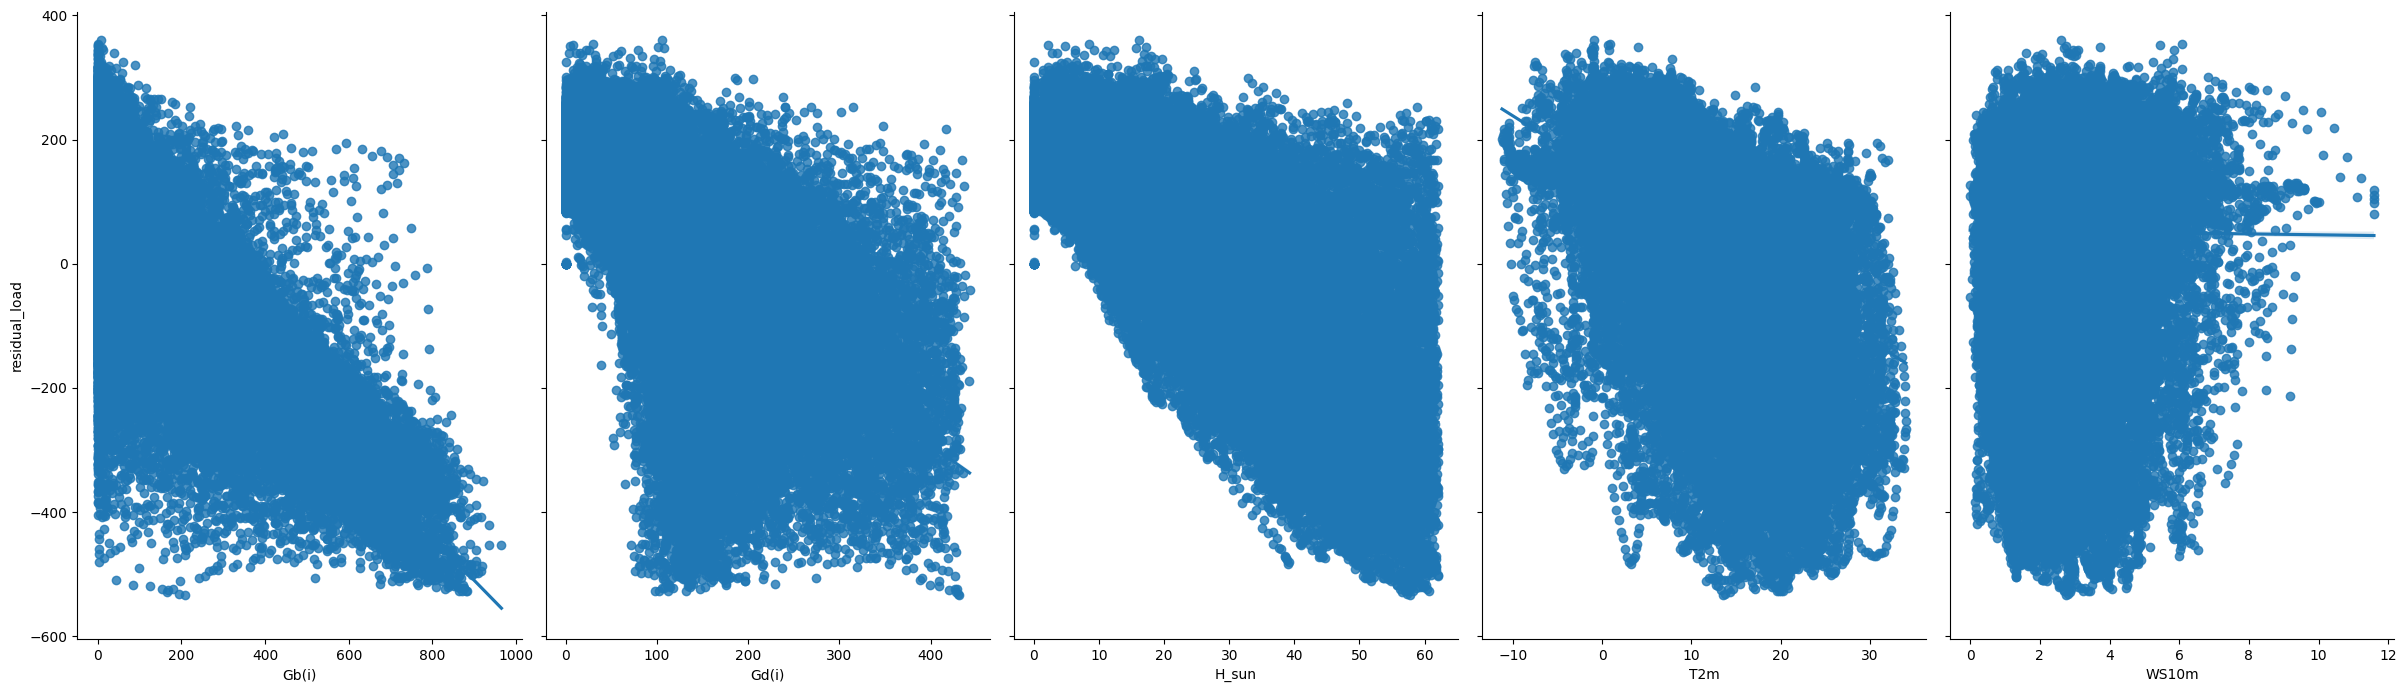

In [9]:
# visualize the relationship between the features and the response using scatter plots
sns.pairplot(train, x_vars=['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m'], y_vars='residual_load', height=7, aspect=0.7, kind='reg')

## Selecting best model

In [10]:
# define the LinearRefression as our prediction model
lm = LinearRegression()
# define the DecisionTreeRegressor as our prediction model
dtrm = DecisionTreeRegressor()
# define the RandomForestRegressor as our prediction model
rfm = RandomForestRegressor()
# Specify the XGBRegressor model
xgbm = XGBRegressor()
# Specify the SVR model
from sklearn.svm import SVR
srvm = SVR()
# Specify the KNeighborsRegressor model
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
# define the ExtraTreeRegressor as our prediction model
from sklearn.ensemble import ExtraTreesRegressor
reg= ExtraTreesRegressor()
# define the ArtifitualNeuralNetwork as our prediction model
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()

In [11]:
# 10 fold cross validation with features
scores = {}
scores['Lm'] = np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['Dtrm'] = np.sqrt(-cross_val_score(dtrm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['Rfm'] = np.sqrt(-cross_val_score(rfm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['Xgbm'] = np.sqrt(-cross_val_score(xgbm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['SRV'] = np.sqrt(-cross_val_score(srvm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['knn'] = np.sqrt(-cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['reg'] = np.sqrt(-cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores['MLP'] = np.sqrt(-cross_val_score(mlp, X, y, cv=10, scoring='neg_mean_squared_error')).mean()
scores

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

{'Lm': 62.14456854847377,
 'Dtrm': 77.3807017468258,
 'Rfm': 56.73947793018893,
 'Xgbm': 57.82107543193452,
 'SRV': 68.19925238858514,
 'knn': 66.61612713326781,
 'reg': 54.99678571886064,
 'MLP': 54.83503343339205}

### The following code splits the data sets with another single line:

In [12]:
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state=4, train_size = 0.8)

## DecisionTreeRegressor

In [13]:
# Predict the train dataset and calculate mean absolute error
dtrm = DecisionTreeRegressor(max_depth=30)
dtrm.fit(train_X, train_y)
val_predictions = dtrm.predict(val_X)
val_mae = {}
val_mae['Dtrm'] = mean_absolute_error(val_y, val_predictions)
val_mae

{'Dtrm': 22.916544055478575}

## RandomForestRegressor

In [14]:
# Predict the train dataset and calculate mean absolute error
rfm = RandomForestRegressor(n_estimators = 400, random_state = 42)
rfm.fit(train_X, train_y)
val_predictions = rfm.predict(val_X)
val_mae['Rfm'] = mean_absolute_error(val_y, val_predictions)
val_mae

{'Dtrm': 22.916544055478575, 'Rfm': 17.128749609785544}

## XGBoost

In [15]:
# Predict the train dataset and calculate mean absolute error
xgbm = XGBRegressor(n_estimators=1000, learning_rate=0.12, max_depth = 10, min_child_weight = 1,
                    scale_pos_weight = 0.5)
xgbm.fit(train_X, train_y)
val_predictions = xgbm.predict(val_X)
val_mae['Xgb'] = mean_absolute_error(val_y, val_predictions)
val_mae

{'Dtrm': 22.916544055478575,
 'Rfm': 17.128749609785544,
 'Xgb': 14.051945862128704}

## I choose the RandomForestRegression Model and in following steps I will find the best running parameter

**Random Search Training**

Now, we instantiate the random search and fit it like any Scikit-Learn model:
The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

### Random Hyperparameter Grid
To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [10, 30, 50, 70, 90, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size = 0.2, random_state = 42)

#--- Use the random grid to search for best hyperparameters
#--- First create the base model to tune
rf = RandomForestRegressor()
#--- Random search of parameters, using 3 fold cross validation, 
#--- search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#--- Fit the random search model
rf_random.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 6.3min
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 5.1min
[CV] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 4.3min
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 9.4min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 3.3min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 6.2min
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 5.2min
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 5.3min
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 9.5min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.8min
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time= 3.3min
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time= 4.5min
[CV] END bootstrap=True, max_depth=30, min_samp

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 30, 50, 70, 90, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 30,
 'bootstrap': True}

In [19]:
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state=42, train_size = 0.8)
rfm = RandomForestRegressor(n_estimators = 800, random_state = 42, max_depth=110, bootstrap = True, max_features=5)
rfm.fit(train_X, train_y)
val_predictions = rfm.predict(val_X)
val_mae['Rfm'] = mean_absolute_error(val_y, val_predictions)
val_mae

{'Dtrm': 22.916544055478575,
 'Rfm': 16.78638298774117,
 'Xgb': 14.051945862128704}

#### We can view the best parameters from fitting the random search:

In [20]:
rfm = RandomForestRegressor(n_estimators = 800, random_state = 42, max_depth=110, bootstrap = True)
rfm.fit(X, y)
test['residual_load'] = rfm.predict(X_test)

# print the top few validation predictions
output = test[['time','residual_load']]
output.to_csv('submission.csv', index=False)

In [21]:
xgbm = XGBRegressor(n_estimators=1000, learning_rate=0.12, max_depth = 10, min_child_weight = 1,
                    scale_pos_weight = 0.5)
xgbm.fit(X, y)
test['residual_load'] = xgbm.predict(X_test)

# print the top few validation predictions
output = test[['time','residual_load']]
output.to_csv('submission_2.csv', index=False)